# Forecasting Bulldozer Prices with Machine Learning 🚜 

In this notebook, we're going to go through an example machine learning project to use the characteristics of bulldozers and their past sales prices to predict the sale price of future bulldozers based on their characteristics.

* **Inputs:** Bulldozer characteristics such as make year, base model, model series, state of sale (e.g. which US state was it sold in), drive system and more.
* **Outputs:** Bulldozer sale price (in USD).

Since we're trying to predict a number, this kind of problem is known as a **regression problem**.

And since we're going to predicting results with a time component (predicting future sales based on past sales), this is also known as a **time series** or **forecasting** problem.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).


## Overview -6 Step Machine Learning Framework
<img src="images/tools.png" alt="tools Image">

### 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

### 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data) we see that it contains historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:

1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

### 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible (a low error value means our model's predictions are close to what the real values are).

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

**`Note`**: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.

### 4. Features - different parts and attributes of the data

 **data dictionary** down below :

#### data dictionary
 

For this dataset, Kaggle provides a data dictionary which contains information about what each attribute of the dataset means. 

For example: 

| Variable Name | Description  | Variable Type |
|------|-----|-----|
| SalesID   | unique identifier of a particular sale of a machine at auction  | Independent  variable |
| MachineID  | identifier for a particular machine; machines may have multiple sales  | Independent  variable |
| ModelID | identifier for a unique machine model (i.e. fiModelDesc) | Independent  variable |
| datasource  | source of the sale record; some sources are more diligent about reporting attributes of the machine than others. Note that a particular datasource may report on multiple auctioneerIDs. | Independent  variable |
| auctioneerID  | identifier of a particular auctioneer, i.e. company that sold the machine at auction. Not the same as datasource.  | Independent  variable |
| YearMade  | year of manufacturer of the Machine  | Independent  variable |
| MachineHoursCurrentMeter | current usage of the machine in hours at time of sale (saledate); null or 0 means no hours have been reported for that sale | Independent  variable |
| UsageBand | value (low, medium, high) calculated comparing this particular Machine-Sale hours to average usage for the fiBaseModel; e.g. 'Low' means this machine has fewer hours given its lifespan relative to the average of fiBaseModel. | Independent  variable |
| Saledate   | time of sale | Independent  variable |
| fiModelDesc  | Description of a unique machine model (see ModelID); concatenation of fiBaseModel & fiSecondaryDesc & fiModelSeries & fiModelDescriptor  | Independent  variable |
| State | US State in which sale occurred | Independent  variable |
| Drive_System | machine configuration; typically describes whether 2 or 4 wheel drive  | Independent  variable |
| Enclosure  | machine configuration - does the machine have an enclosed cab or not | Independent  variable |
| Forks  | machine configuration - attachment used for lifting  | Independent  variable |
| Pad_Type | machine configuration - type of treads a crawler machine uses | Independent  variable |
| Ride_Control  | machine configuration - optional feature on loaders to make the ride smoother | Independent  variable |
| Transmission | machine configuration - describes type of transmission; typically automatic or manual | Independent  variable |
| ... | ... | ... |
| SalePrice | cost of sale in USD | Target/dependent variable | 

You can download the full version of this file directly from the [Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (Kaggle account required) or view it [on Google Sheets](https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing).

#### Import Tools, data and preparing it for modelling

In [1]:
# Tools :
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn

##### How to acsses the data in GoogleColab:

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/Bulldozer-data/TrainAndValid.csv'
# import pandas as pd
# df = pd.read_csv(file_path)
# df.head()


##### Read data localy:

In [3]:
# lets take a look on the data...
df = pd.read_csv("data/TrainAndValid.csv" ,  low_memory=False)
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


##### info:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

##### Missing values?:

In [14]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

##### Sales price: 

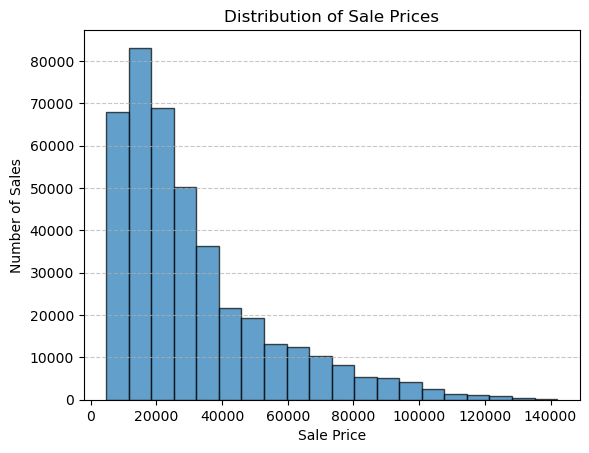

In [24]:
df.SalePrice.plot.hist(bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Number of Sales")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### **Parsing dates - Sale Price Over Time**

When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object]

We can tell pandas which columns to read in as dates by setting the `parse_dates` parameter in [`pd.read_csv`]

Once we've imported our CSV with the `saledate` column parsed, we can view information about our DataFrame again with `df.info()`. 

In [31]:
# Import data again but this time parse dates
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])

In [27]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

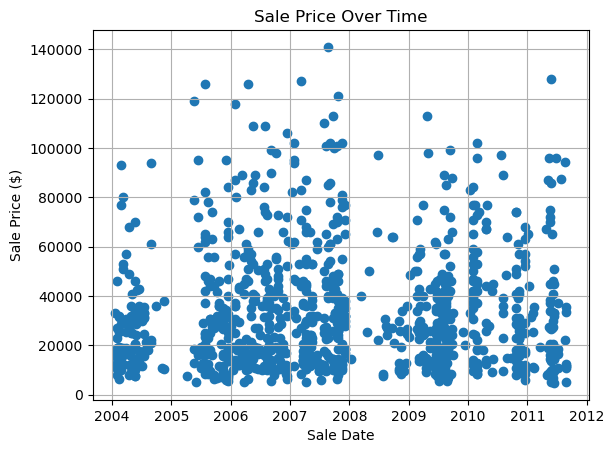

In [35]:
fig, ax = plt.subplots()
ax.scatter(x=df["saledate"][:1000], # visualize the first 1000 values
           y=df["SalePrice"][:1000])
ax.set_xlabel("Sale Date")
ax.set_ylabel("Sale Price ($)")
ax.set_title("Sale Price Over Time")
ax.grid(True)
